# Linear interpolation and inverse distance weighting (IDW) in 1-D

Similar to the example of regression, we will briefly evaluate linear interpolation and IDW 1-D. This is a very simplified example - but will show us the basic principles that we can then extend to higher dimensions - and understand why some things work and some may not.

This notebook is part of the class "Structural Geological Models".

(c) Florian Wellmann, CG3, 2023

## Brief review of the theory



In [2]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # needed to load the background image

## Input data

We will use again the image from the lecture with the well markers from the virtual drillholes. You can use the same input points as before.

Set the position of the input points and plot them above the image:

In [3]:
# x-positions of points:
x_positions = [4, 5.2, 10, 16.5, 17.5]

# y-positions of points:
y_positions = [5, 5, 5.8, 5.2, 4.9]

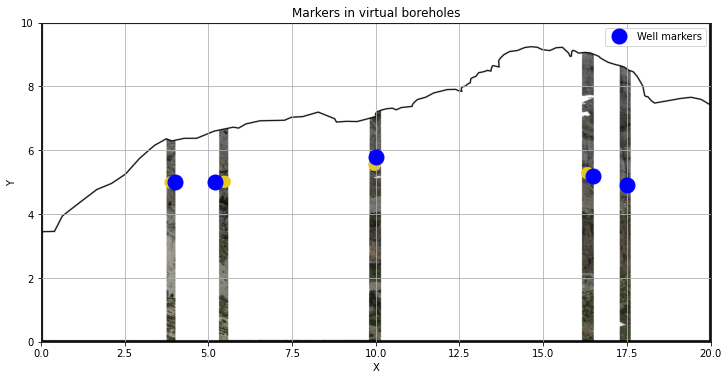

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load your image using matplotlib's imread
image_path = 'WandC_boreholes_2.png'  # Replace with the path to your image file
img = mpimg.imread(image_path)

# Determine the aspect ratio of the image
image_aspect_ratio = img.shape[1] / img.shape[0]

# Create a figure with the aspect ratio of the image
fig, ax = plt.subplots(figsize=(12, 12 / image_aspect_ratio))

# Display the image with the same aspect ratio
ax.imshow(img, extent=[0, 20, 0, 10], aspect='auto')

# Set limits, labels, title, etc.
ax.set_xlim(0, 20)
ax.set_ylim(0, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Markers in virtual boreholes')

plt.grid()

# Example data plot
ax.plot(x_positions, y_positions, 'o', markersize=15, color='blue', label='Well markers')
ax.legend();

# Show the plot
plt.show()


Adjust the positions until you receive a good match to the markers.

## Linear interpolation

Viewing linear interpolation results is actually almost too easy in matplotlib: a line connecting input points is default behavior. But for a repetition of theory, first implement a function to calculate the Lagrange interpolating polynomial between a set of input points.




In [5]:
from scipy.interpolate import lagrange

def lagrange_interpolation(x_points, y_points):
    """
    Calculate and plot the Lagrange interpolating polynomial.

    :param x_points: List of x-coordinates of the points.
    :param y_points: List of y-coordinates of the points.
    """
    # Calculate the Lagrange interpolating polynomial
    polynomial = lagrange(x_points, y_points)

    # Generate a dense range of x values for plotting
    x_dense = np.linspace(0, 20, 500)

    # Evaluate the polynomial at the dense x values
    y_dense = polynomial(x_dense)

    return x_dense, y_dense


Note: by default, the degree of the polynomial is chosen to be one less than the number of provided input points

**Your task**: test this function with several sets of input points and plot the results in the combined figure:

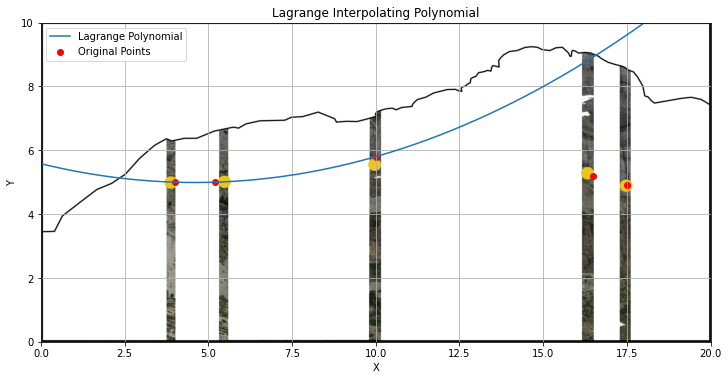

In [6]:
x_dense, y_dense = lagrange_interpolation(x_positions[:3], y_positions[:3])

fig, ax = plt.subplots(figsize=(12, 12 / image_aspect_ratio))

# Display the image with the same aspect ratio
ax.imshow(img, extent=[0, 20, 0, 10], aspect='auto')

# Set limits, labels, title, etc.
ax.set_xlim(0, 20)
ax.set_ylim(0, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Markers in virtual boreholes')

plt.grid()

# Plot the original points
plt.scatter(x_positions, y_positions, color='red', label='Original Points')

# Plot the Lagrange interpolating polynomial
plt.plot(x_dense, y_dense, label='Lagrange Polynomial')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lagrange Interpolating Polynomial')
plt.legend()

# Show the plot
plt.show()

### Experiment with data and interpolation

Test the following aspects to get a better insight into the results:
- Test the interpolation for different sets of input points. As in the regression example: calculate the difference between prediction and actual values at the points that are left out.

## Inverse Distance Weighting (IDW)

Next, we perform an interpolation using inverse distance weighting. Here, also in 1-D - but as we discussed in the lecture, the extension of the concept to 2-D is fairly straight-forward.

Inverse Distance Weighting (IDW) is a method used for interpolating values at unknown points based on values from known points. The fundamental idea behind IDW is that the estimated value at an unknown point should be influenced more by closer known points than by those farther away. This influence typically decreases with distance.

### Theory

The IDW interpolated value $I(x)$ at a point $x$ can be computed using the formula:

$$
I(x) = \frac{\sum_{i=1}^{n} \frac{1}{d(x, x_i)^p} \cdot y_i}{\sum_{i=1}^{n} \frac{1}{d(x, x_i)^p}}
$$

where:
- $n$ is the number of known points,
- $x_i$ are the known points,
- $y_i$ are the values at the known points,
- $d(x, x_i)$ is the distance between the unknown point $x$ and a known point $x_i$,
- $p$ is a power parameter that determines how quickly the influence of known points decreases with distance. A larger value of $p$ gives greater influence to nearer points.

In the case of 1-D interpolation, the distance $d(x, x_i)$ is simply the absolute difference between $x$ and $x_i$:

$$
d(x, x_i) = |x - x_i|
$$

It's important to handle the case where the unknown point $x$ coincides with one of the known points $x_i$. In this scenario, the interpolated value $I(x)$ should be exactly equal to the value at the known point, $y_i$.

Shepard's method for smoothing is a specific implementation of IDW interpolation where the power parameter $p$ is typically set to 2, although it can be adjusted for different smoothing effects.

### Implementation

Here is a simple implementation in Python:


In [7]:
# Function for Inverse Distance Weighting using Shepard's method
def inverse_distance_weighting(x, xi, values, power=2):
    """
    Apply Inverse Distance Weighting interpolation.

    :param x: Array of points where interpolation is computed.
    :param xi: Known data points.
    :param values: Values at the known data points.
    :param power: Power parameter for weights. Higher value means more influence to nearer points.
    :return: Interpolated values at points x.
    """
    # Initialize array to store interpolated values
    interpolated_values = np.zeros(len(x))

    # Iterate over each point in x
    for i in range(len(x)):
        # Compute weights based on inverse distance
        weights = 1 / (np.abs(x[i] - xi) ** power)
        
        # Handle case where x[i] is exactly one of the xi (to avoid division by zero)
        if np.any(weights == np.inf):
            interpolated_values[i] = values[np.argmax(weights)]
        else:
            # Calculate the weighted average
            interpolated_values[i] = np.sum(weights * values) / np.sum(weights)

    return interpolated_values


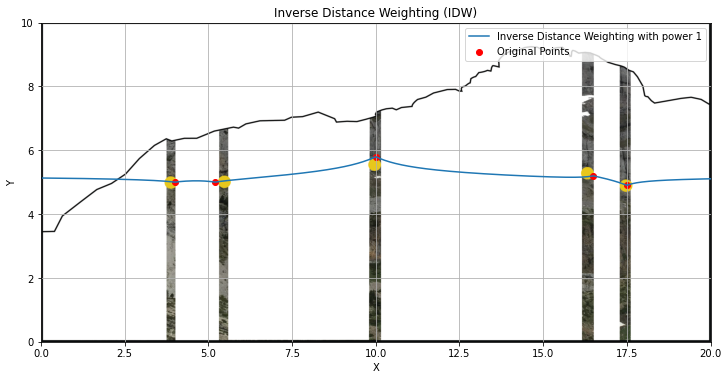

In [8]:
# set the power value (Shepards method):
power = 1

# Apply IDW interpolation
y_dense = inverse_distance_weighting(x_dense, x_positions, y_positions, power=power)

fig, ax = plt.subplots(figsize=(12, 12 / image_aspect_ratio))

# Display the image with the same aspect ratio
ax.imshow(img, extent=[0, 20, 0, 10], aspect='auto')

# Set limits, labels, title, etc.
ax.set_xlim(0, 20)
ax.set_ylim(0, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Markers in virtual boreholes')

plt.grid()

# Plot the original points
plt.scatter(x_positions, y_positions, color='red', label='Original Points')

# Plot the Lagrange interpolating polynomial
plt.plot(x_dense, y_dense, label='Inverse Distance Weighting with power %d' % power)

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Inverse Distance Weighting (IDW)')
plt.legend()

# Show the plot
plt.show()

### Experiment with data and interpolation

In order to get a feeling for the interpolation, experiment with the settings:
- Try to make the points more extreme (changing the position of well-markers, for example): how robust is the result, compared to regression and simple interpolation before?
- As before: remove points and calculate the (vertical) error of the prediction.
- Test the influence of the `power`-parameter on the results (i.e.: smoothing around the data points)